# Purpose

Throughout a race the speed of an F1 car changes dramatically.  Maximized at the end of a straight before hard braking zones, with smooth acceleration out of each corner.  The speed v.s. time curve is the most iconic piece of telemetry used for interpreting a driver's lap quality.  The subtle differences in breaking points and throttle control distinguish the goods from the greats.  Not to mention not all cars are equal!  Though the differences are subtle, here I hope to show that a Neural Net is capable of distinguishing the driver given a speed telemetry curve.

In this notebook I aim to demonstrate the ability to identify the driver in question solely based off of a speed telemetry trace using a *Supervised Neural Network* trained a subset of laps obtained from the F1 2022 season using the [fastf1](https://theoehrly.github.io/Fast-F1) package.

# Method

Telemetry traces are obtained for each track using the [fastf1](https://theoehrly.github.io/Fast-F1) package.  This tool does not provide data sampled at a regular rate, so some data cleaning is required for their use in this notebook.  This has been performed in advance using the functions provided by the [f1_djsouthall/tools/fastf1_tools.py](https://github.com/djsouthall/f1_djsouthall/blob/main/tools/fastf1_tools.py) script.  These laps are resampled to 0.1 second sampling, and all non-standard laps have been removed (i.e. laps with a safety car, yellow flags, pitstop in-lap, pitstop out-lap).  These standardized laps are loaded here and used for training the NN.

I am using the [tensorflow](https://www.tensorflow.org/) and [keras](https://keras.io/) APIs to construct and train this model.

In [1]:
# Perform imports and setup code

disable_gpu = False # Helpful for debugging, sometimes performs differently with GPU enabled. 

# OS imports
import os
import sys

# Common imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
%matplotlib widget
plt.ion()

# F1 imports
import fastf1
import fastf1.plotting
fastf1.Cache.enable_cache(os.environ['f1_cache'])  
sys.path.append(os.environ['f1_install'])
from tools.fastf1_tools import loadTelemForYear, loadTelemForEvent

# ML imports
import tensorflow as tf

if disable_gpu:
    try:
        # Disable all GPUS
        tf.config.set_visible_devices([], 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    tf.config.set_visible_devices([], 'GPU')
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from tensorflow import keras
import keras_tuner
from keras import optimizers

# Check for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Number of GPUs Available: {}'.format(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Disable warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

Number of GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Next we load in the lap telemetry and filter it down to the subset of drivers and tracks we wish to train on. 

In [2]:
# Load and filter lap telemetry.

# Get speed traces for Max in Abu Dhabi 2022 GP
schedule = fastf1.get_event_schedule(year=2022, include_testing=False)
event = schedule.get_event_by_round(1)
session = event.get_session('R')
session.load()

path = os.path.join(os.environ['f1_install'], 'dataframes')
telem_param = 'Speed'

refined_laps = loadTelemForEvent(event, path=path, telem_param=telem_param) # Formatted laps generated by ml/save_lap_telemetry.py
# Here we can filter to a subset of drivers
all_drivers = np.unique([c.split('_')[0] for c in refined_laps.columns])

# For simplificity here we can reduce the number of drivers to consider
# or use the fully available set.
if True:
    choose_drivers = all_drivers
else:
    choose_drivers = ['VER', 'PER', 'LEC', 'SAI', 'HAM', 'RUS'] # Some subset to simplify the problem down to a handful of drivers first

columns = refined_laps.columns[[np.isin(c.split('_')[0], choose_drivers) for c in refined_laps.columns]] # Select subset of columns relevant to selected drivers
refined_laps = refined_laps[columns]

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']


Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Bahrain_Grand_Prix_2022.pkl


Here we randomize the lap order.  Though keras shuffles these as well, I choose to do so in advance here for clarity.

At this stage I also clip the laps to the shortest lap of the year to remove NaN values where lap lengths differ.

In [3]:
randomized_indices = np.random.choice(range(len(refined_laps.columns)), len(refined_laps.columns))
refined_laps = refined_laps.iloc[:, randomized_indices]# Shuffled randomly
refined_laps = refined_laps.dropna() # Will cut off laps beyond shortest lap of the season.  But is a quick way to normalize data. 

print('Column label format: {DRIVER}_{LAP_ID}')
print(refined_laps.head().T.head(4).T) #Print the head of the first 4 laps

Column label format: {DRIVER}_{LAP_ID}
                            RUS_22      HUL_34      LAT_34      MSC_40
0 days 00:00:00         275.000000  273.500000  283.500000  282.000000
0 days 00:00:00.100000  275.375000  274.625000  283.875000  282.750000
0 days 00:00:00.200000  275.807692  275.576923  284.307692  283.615385
0 days 00:00:00.300000  277.287500  276.200000  284.775000  284.212500
0 days 00:00:00.400000  277.764463  276.735537  285.260331  284.739669


Next we quickly plot the laps, helpful for checking the data is sensible.  

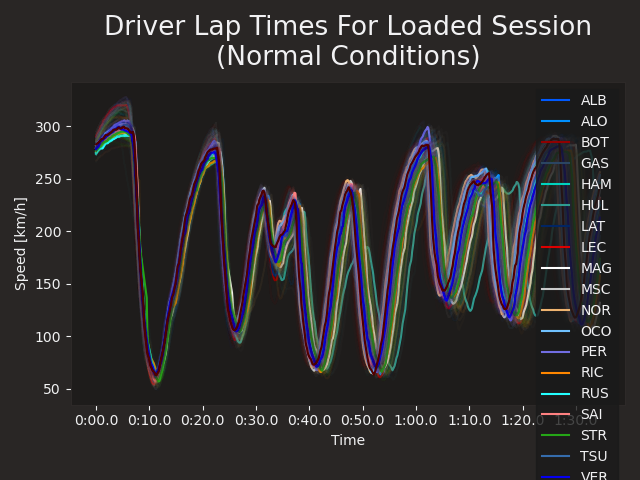

In [4]:
# Quickly plot laps
plt.figure()

for driver in choose_drivers:
    driver_laps = refined_laps.loc[:, refined_laps.columns.str.match('{}*'.format(driver))]
    laptimes = driver_laps.notna()[::-1].idxmax()
    min_lap = laptimes.argmin()
    max_lap = laptimes.argmax()
    for i, (lap_name, lap) in enumerate(driver_laps.iteritems()):
        plt.plot(lap, alpha=1.0 if i == min_lap else 1.0/len(driver_laps.columns), c=fastf1.plotting.driver_color(driver), label=driver if i == min_lap else None)

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.ylabel('Speed [km/h]')
plt.xlabel('Time')
plt.title('Driver Lap Times For Loaded Session\n(Normal Conditions)')
plt.tight_layout()

At this point we have obtained a set of consistently formatted (sampled equally in time and of equal length) speed traces.

# Sort Data
Here we split the data into training and testing data.  We then process the labels with a vectorizer and prepare the datasets as tensors.


In [5]:
# Get numpy array where each row is lap, and obtain labels. 
np_laps = refined_laps.to_numpy().T #Will cut off laps longer than shortest lap in the calander.
labels = np.asarray([c.split('_')[0] for c in refined_laps.columns])

training_percent = 0.9

training_n = int(training_percent*len(refined_laps.columns))
training_indices = np.random.choice(range(len(refined_laps.columns)), size=training_n, replace=False)

testing_indices = np.arange(len(refined_laps.columns))[~np.isin(np.arange(len(refined_laps.columns)), training_indices)]

print('Training on {} laps, and testing on {}'.format(len(training_indices), len(testing_indices)))


Training on 787 laps, and testing on 88


In [6]:
# Prepare preprocessing
scaler = keras.layers.Rescaling(scale=1.0/np.nanmax(np_laps))
vectorizer = keras.layers.TextVectorization(output_mode="int")
vectorizer.adapt(np.unique(labels))
num_classes = len(np.unique(labels))

# Prepare Training Data
training_labels = vectorizer(labels[training_indices]) - 2
training_data = scaler(np_laps[training_indices])#tf.convert_to_tensor(np_laps[training_indices])

# # Preparing Testing Data
testing_labels = vectorizer(labels[testing_indices]) - 2
testing_data = scaler(np_laps[testing_indices])#tf.convert_to_tensor(np_laps[testing_indices])

label_key = vectorizer.get_vocabulary()[2:] #Strip off the '' and 'UNK' options.
label_dict = dict([(vectorizer(l).numpy()[0] - 2, l) for l in vectorizer.get_vocabulary()[2:]]) # [2:] strips off the '' and 'UNK' default 0 and 1 values from vectorizer. - 2 accounts for shifting these such that labels start at 0.

print(label_dict)

{0: 'zho', 1: 'ver', 2: 'tsu', 3: 'str', 4: 'sai', 5: 'rus', 6: 'ric', 7: 'per', 8: 'oco', 9: 'nor', 10: 'msc', 11: 'mag', 12: 'lec', 13: 'lat', 14: 'hul', 15: 'ham', 16: 'gas', 17: 'bot', 18: 'alo', 19: 'alb'}


## Preparing Model
Now we start preparing the model.

In [7]:
convolutional = False # Still working on CNN, only NN tested right now.  

if convolutional == False:
    model = keras.models.Sequential([
        keras.layers.Dense(units=50, activation='tanh', input_shape=(training_data.shape[1],)),
        keras.layers.Dense(units=32, activation='tanh'),
        keras.layers.Dense(units=16, activation='tanh'),
        keras.layers.Dense(units=len(label_dict), activation='softmax')
        ])
else:
    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=32, kernel_size=20, activation='relu', padding='same', input_shape=(training_data.shape[1],1,)),
        keras.layers.Dense(units=32, activation='tanh'),
        keras.layers.Dense(units=40, activation='tanh'),
        keras.layers.Dense(units=len(label_dict), activation='softmax')
        ])

# optimizer = optimizers.Adam(clipvalue=0.5)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)#RMSprop
model.summary()

# Using accuracy as the metric below seems important. I originally was using categorical accuracy and it was causing
# problems that I could not quite understand.  Accuracy works well though. 
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=['accuracy']) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                47350     
                                                                 
 dense_1 (Dense)             (None, 32)                1632      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 20)                340       
                                                                 
Total params: 49,850
Trainable params: 49,850
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [9]:
# Perform checks on data
assert np.any(np.isnan(training_data)) == False
assert np.any(np.isnan(training_labels)) == False
assert np.any(np.isnan(testing_data)) == False
assert np.any(np.isnan(testing_labels)) == False
assert type(training_data) == type(training_labels)

print('Training on {} laps, and testing on {}, attempting to distinguish between {} drivers.'.format(training_data.shape[0], testing_data.shape[0], len(np.unique(training_labels))))
model.fit(training_data, training_labels, batch_size=20, epochs=5000, verbose=0)#, validation_split=0.2

result = model.evaluate(testing_data,testing_labels,verbose=1)

# Changing the accuracy into a percentage
testing_acc = result[1]*100
# Printing the accuracy
print('Test Accuracy - ', testing_acc,'%')
print(dict(zip(model.metrics_names, result)))


Training on 787 laps, and testing on 88, attempting to distinguish between 20 drivers.
3/3 [==============================] - 0s 4ms/step - loss: 0.7042 - accuracy: 0.8182
Test Accuracy -  81.81818127632141 %
{'loss': 0.7042233943939209, 'accuracy': 0.8181818127632141}


3/3 [==============================] - 0s 5ms/step - loss: 0.7042 - accuracy: 0.8182
Test Accuracy -  81.81818127632141 %
{'loss': 0.7042233943939209, 'accuracy': 0.8181818127632141}
Looping through the testing data and checking results:
    1/88   : True:  SAI  Predicted:  SAI  | Correct | Choice probability = 99.6%
    2/88   : True:  ZHO  Predicted:  ZHO  | Correct | Choice probability = 85.3%
    3/88   : True:  HUL  Predicted:  HUL  | Correct | Choice probability = 99.3%
    4/88   : True:  TSU  Predicted:  TSU  | Correct | Choice probability = 99.3%
    5/88   : True:  STR  Predicted:  RUS  |  Wrong  | Choice probability = 82.2%
    6/88   : True:  ALO  Predicted:  ALO  | Correct | Choice probability = 99.2%
    7/88   : True:  MSC  Predicted:  MSC  | Correct | Choice probability = 99.2%
    8/88   : True:  ALO  Predicted:  ALO  | Correct | Choice probability = 99.9%
    9/88   : True:  TSU  Predicted:  TSU  | Correct | Choice probability = 90.3%
   10/88   : True:  TSU  Predicte

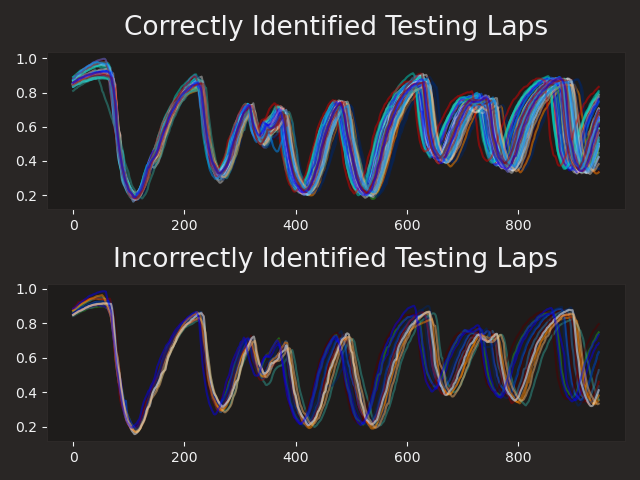

In [10]:
result = model.evaluate(testing_data,testing_labels,verbose=1)

# Changing the accuracy into a percentage
testing_acc = result[1]*100
# Printing the accuracy
print('Test Accuracy - ', testing_acc,'%')
print(dict(zip(model.metrics_names, result)))

predictions = model(testing_data, training=False)
print('Looping through the testing data and checking results:')

plt.figure()
ax1 = plt.subplot(2,1,1)
ax1.title.set_text('Correctly Identified Testing Laps')
ax2 = plt.subplot(2,1,2)
ax2.title.set_text('Incorrectly Identified Testing Laps')
for i, (expect, predict) in enumerate(zip(testing_labels.numpy() , predictions.numpy())):
    print('{:5}/{:<5}: True:{:^7}Predicted:{:^7}| {:^7} | Choice probability = {:.1f}%'.format(i+1, testing_data.shape[0], label_dict[expect[0]].upper(), label_dict[predict.argmax()].upper(), ['Wrong', 'Correct'][predict.argmax() == expect[0]],  predict.max()*100))
    [ax2, ax1][predict.argmax() == expect[0]].plot(testing_data.numpy()[i], c=fastf1.plotting.driver_color(label_dict[expect[0]].upper()), alpha=0.5)

plt.tight_layout()


# Conclusions

Using machine learning with *keras* and *tensorflow* we have been able to create a model capable of distinguishes drivers with moderae success (currently ~80% prediction accuracy when picking among 20 drivers).  Some refining is necessary to improve this, which will be interesting to continue tackling.  But given the tremendously subtle differences in telemetry I think this rate is already very interesting.  Unlike determining a track based on a particular trace (shown in [f1_djsouthall/ml/guess_track_from_telem.ipynb](https://github.com/djsouthall/f1_djsouthall/blob/main/ml/guess_track_from_telem.ipynb)) - which I could imagine developing a relatively simple algorithm to solve, distinguishing drivers from traces is complicated and subtle.  So I consider this early result a partial success!

Further improvements could be obtained by adjusting the model with different layers such as convolutional layers.  Additionally this model is currently only trained on a single track.  Though my guess is that using more tracks would comlicate the model further, it does provide more examples of each drivers habits and could potentially change the outcome.

# See Also

* I am applied this same framework to distinguish between tracks using speed telemetry traces, which was very successful.  Please check that out if you wish to see more: [f1_djsouthall/ml/guess_track_from_telem.ipynb](https://github.com/djsouthall/f1_djsouthall/blob/main/ml/guess_track_from_telem.ipynb)

* I have also been playing with the fastf1 tool to scrape other forms of F1 race data and store this data into SQL databases.  To see that work please look at the work found in [f1_djsouthall/sql/make_tables.py](https://github.com/djsouthall/f1_djsouthall/tree/main/sql/make_tables.py) (for SQL table creation) and [f1_djsouthall/sql/example_sql_analysis.py](https://github.com/djsouthall/f1_djsouthall/tree/main/sql/example_sql_analysis.py) (for example analysis performed using that database).